# Crypto Market Exploratory Data Analysis project

## Preparing data files
Crypto market data is extracted from Binance Exchange via Binance API.

Connection to Binance API with Python is made using library [python-binance v1.0.16](https://python-binance.readthedocs.io/en/latest/index.html)

In [33]:
from binance.client import Client

# API KEYS
api_key = "..."    #Enter your own API-key here
api_secret = "..." #Enter your own API-secret here

client = Client(api_key, api_secret)

Adding [Pandas](https://pandas.pydata.org/docs/) tool to the project's environment.

In [3]:
import pandas as pd
import datetime

Extracting tickers (cryptocurrency pairs symbols) from Binance.

Putting them into Pandas data frame.

In [49]:
tickers = client.get_all_tickers()
df_tickers = pd.DataFrame(tickers)
df_tickers

,symbol,price
0,ETHBTC,0.07405200
1,LTCBTC,0.00449100
2,BNBBTC,0.01710700
3,NEOBTC,0.00040600
4,QTUMETH,0.00173700
...,...,...
2128,VITEBUSD,0.02433000
2129,HOOKBTC,0.00014056
2130,HOOKUSDT,2.38640000
2131,HOOKBUSD,2.38540000


Some data transformation steps to get rid of unnecesary columns and extract only USDT currency pairs.

In [50]:
df_tickers.drop(columns=['price'], axis=1, inplace=True)
df_tickers = df_tickers[df_tickers['symbol'].str.endswith("USDT")]
df_tickers = df_tickers.reset_index()
df_tickers = df_tickers.rename(columns={"index":"id"})
df_tickers['id'] = df_tickers.index + 1
df_tickers.to_csv('df_tickers.csv') # extracting to CSV file for further analysis
df_tickers

,id,symbol
0,1,BTCUSDT
1,2,ETHUSDT
2,3,BNBUSDT
3,4,BCCUSDT
4,5,NEOUSDT
...,...,...
412,413,APTUSDT
413,414,OSMOUSDT
414,415,HFTUSDT
415,416,PHBUSDT


Extracting crypto pairs data into CSV files.

In [39]:
def binanceBarExtractor(symbol):
    filename = 'extracted_data/{}_1dBars.csv'.format(symbol)

    # method to fetch data of certain crypto pair (symbol), on certain Time Frame(KLINES_INTERVAL_) 
    # and time period(for starting point it uses method that searches Binance for earliest timestamp; stop point is default - the latest available )
    klines = client.get_historical_klines(symbol, Client.KLINE_INTERVAL_1DAY, client._get_earliest_valid_timestamp(symbol, '1d'), None, 1000)
    
    # Transforming 'klines' into Pandas Date Frame, adding proper formatting for date column and saving it into CSV file
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data.drop(columns=['ignore'], axis=1, inplace=True) # dropping unnecessary column from data set
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    data.set_index('timestamp', inplace=True)
    data.to_csv(filename) # saving to CSV file

In [40]:
# running 'binanceBarExtractor' method with its 'symbol' argument over 'df_tickers' symbols list
for index, row in df_tickers.iterrows():
    binanceBarExtractor(row['symbol'])

Files with data about cryptocurrency pairs are extracted to 'extracted_data' folder.

## EDA

In [9]:
# setting option for better decimal number display
pd.set_option('display.float_format', '{:.2f}'.format)

Charts are created using [Plotly Express](https://plotly.com/python/plotly-express/) tool and then viewed as PNG static image ([with Kaleido engine](https://plotly.com/python/static-image-export/)).

In [8]:
import plotly.express as px
import plotly.io as pio

Let's read an example cryptopair data set and examine information it holds

In [4]:
cryptopair_example = pd.read_csv('extracted_data/BTCUSDT_1dBars.csv')
cryptopair_example

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.15,1503014399999,3454770.05,3427,616.25,2678216.40
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.89,1503100799999,5086958.31,5233,972.87,4129123.32
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.31,1503187199999,1549483.74,2153,274.34,1118001.87
3,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.08,1503273599999,1930364.39,2321,376.80,1557401.33
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.74,1503359999999,2797231.71,3972,557.36,2255662.55
...,...,...,...,...,...,...,...,...,...,...,...
1931,2022-11-30,16442.91,17249.00,16428.30,17163.64,303019.81,1669852799999,5123595199.51,6519330,151764.57,2566042183.00
1932,2022-12-01,17165.53,17324.00,16855.01,16977.37,232818.18,1669939199999,3972607179.87,5097720,116018.89,1979692808.01
1933,2022-12-02,16978.00,17105.73,16787.85,17092.74,202372.21,1670025599999,3432385161.66,4305515,99556.14,1688510144.19
1934,2022-12-03,17092.13,17188.98,16858.74,16885.20,154542.57,1670111999999,2622504252.87,3308694,76214.57,1293351463.16


Columns descritpion <br><br>
*'timestamp' ----> Time frame open time <br>
'open' ----> Open price<br>
'high' ----> Highest price<br>
'low' ----> Lowest price <br>
'close' ----> Close price <br>
'volume' ----> Volume <br>
'close_time' ----> Time frame close time <br>
'quote_av' ----> Quote asset volume <br>
'trades' ----> Number of trades <br>
'tb_base_av' ----> Taker buy base asset volume <br>
'tb_quote_av' ----> Taker buy quote asset volume <br>*


### Daily average number of trades

Loading previously extracted list of tickers

In [4]:
tickers = pd.read_csv('df_tickers.csv')
tickers.drop(columns='Unnamed: 0', inplace=True)
tickers

,id,symbol
0,1,BTCUSDT
1,2,ETHUSDT
2,3,BNBUSDT
3,4,BCCUSDT
4,5,NEOUSDT
...,...,...
412,413,APTUSDT
413,414,OSMOUSDT
414,415,HFTUSDT
415,416,PHBUSDT


In [5]:
average_trades = [] # creating a List variable that will hold cryptopairs symbols and their daily average number of trades

for index, row in tickers.iterrows():
    # reading a CSV data file that corresponds to the 'symbol' taken from 'tickers' list
    cryptopair = pd.read_csv('extracted_data/{}_1dBars.csv'.format(row['symbol'])) 
    # putting 'symbol' into 'average_trades' list and corresponding Average number of trades calculated with 'mean()' function
    average_trades.append( {'symbol': row['symbol'] , 'average_num_of_trades': cryptopair["trades"].mean()} )

df_average_trades = pd.DataFrame(average_trades) # changing List into Data Frame
df_average_trades.to_csv('df_average_trades.csv')


In [25]:
df_average_trades = pd.read_csv('df_average_trades.csv')
df_average_trades.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

# sorting crypto pairs by 'average_num_of_trades'
top_10_trades = df_average_trades.nlargest(10,'average_num_of_trades')
top_10_trades

,symbol,average_num_of_trades
0,BTCUSDT,1180485.96
287,SHIBUSDT,610361.06
1,ETHUSDT,535490.24
392,GMTUSDT,501512.32
119,SOLUSDT,391926.25
53,DOGEUSDT,380415.60
171,DOTUSDT,360204.93
2,BNBUSDT,327877.00
330,GALAUSDT,322155.39
73,BUSDUSDT,315422.20


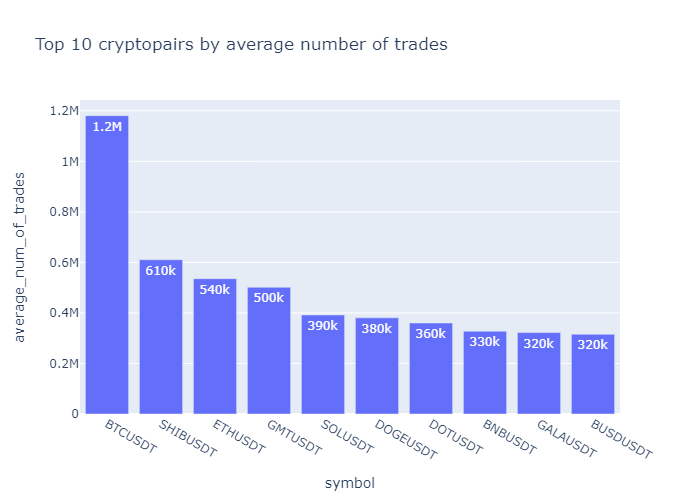

In [10]:
fig1 = px.bar(top_10_trades, x='symbol', y='average_num_of_trades', title="Top 10 cryptopairs by average number of trades", text_auto='.2s')
fig1.show("png")

### Average daily volume
Average daily transaction volume in USDT at time frame close price.

In [11]:
average_vol = []

for index, row in tickers.iterrows():
    # reading a CSV data file that corresponds to the 'symbol' taken from 'tickers' list
    cryptopair = pd.read_csv('extracted_data/{}_1dBars.csv'.format(row['symbol'])) 
    # putting 'symbol' into 'average_vol' list and corresponding Average volume price calculated with 'mean()' function 
    # multiplied by 'close' price
    average_vol.append( {'symbol': row['symbol'] , 'average_volume': (cryptopair['volume']*cryptopair['close']).mean()} )

df_average_vol = pd.DataFrame(average_vol) # changing List into Data Frame
df_average_vol.to_csv('df_average_volume.csv')

In [12]:
df_average_vol = pd.read_csv('df_average_volume.csv')
df_average_vol.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

# sorting crypto pairs by 'average_volume'
top_10_volume = df_average_vol.nlargest(10,'average_volume')
top_10_volume

,symbol,average_volume
0,BTCUSDT,1435262787.65
1,ETHUSDT,717025931.11
73,BUSDUSDT,528107309.08
287,SHIBUSDT,353521907.74
53,DOGEUSDT,314349899.49
2,BNBUSDT,247577923.65
392,GMTUSDT,244052930.22
171,DOTUSDT,232655693.92
119,SOLUSDT,230732441.85
8,XRPUSDT,225787025.80


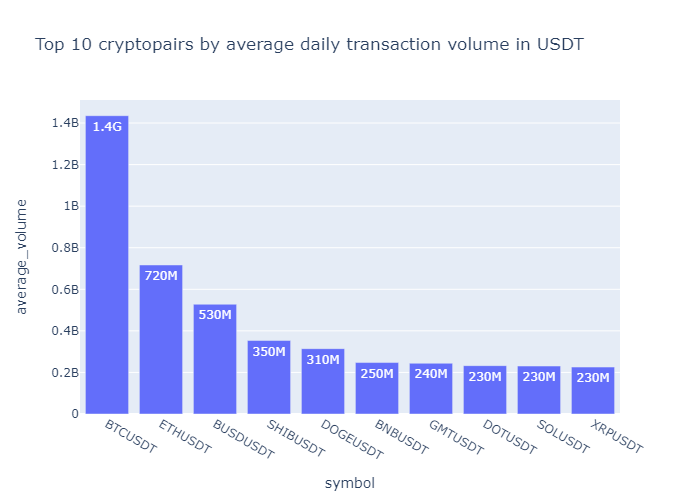

In [13]:
fig2 = px.bar(top_10_volume, x='symbol', y='average_volume', title="Top 10 cryptopairs by average daily transaction volume in USDT", text_auto='.2s')
fig2.show("png")

### TOP 5 cryptocurrencies on Binance for last 5 years

Cryptocurrencies that made it to top 10 average daily volume and number of trades.

In [98]:
comparison = top_10_trades.set_index('symbol').join(top_10_volume.set_index('symbol'), how='inner')
comparison

,average_num_of_trades,average_volume
symbol,,
BTCUSDT,1180485.96,1435262787.65
SHIBUSDT,610361.06,353521907.74
ETHUSDT,535490.24,717025931.11
GMTUSDT,501512.32,244052930.22
SOLUSDT,391926.25,230732441.85
DOGEUSDT,380415.60,314349899.49
DOTUSDT,360204.93,232655693.92
BNBUSDT,327877.00,247577923.65
BUSDUSDT,315422.20,528107309.08


Creating ranking system for cryptopairs. Giving points equal to the place cryptopair made in certain TOP 10 list.

In [99]:
#comparison['value'] = comparison['average_num_of_trades'] * comparison['average_volume']
comparison.sort_values(by=['average_num_of_trades'],ascending=True,inplace=True)
comparison.reset_index(inplace=True)
comparison = comparison.rename(columns={'index':'trades_sort'})
comparison['trades_sort'] = comparison.index + 1
comparison
#comparison.reset_index()


,symbol,average_num_of_trades,average_volume,trades_sort
0,BUSDUSDT,315422.20,528107309.08,1
1,BNBUSDT,327877.00,247577923.65,2
2,DOTUSDT,360204.93,232655693.92,3
3,DOGEUSDT,380415.60,314349899.49,4
4,SOLUSDT,391926.25,230732441.85,5
5,GMTUSDT,501512.32,244052930.22,6
6,ETHUSDT,535490.24,717025931.11,7
7,SHIBUSDT,610361.06,353521907.74,8
8,BTCUSDT,1180485.96,1435262787.65,9


In [100]:
comparison.sort_values(by=['average_volume'],ascending=True,inplace=True)
comparison.reset_index(inplace=True)
comparison = comparison.rename(columns={'index':'volume_sort'})
comparison['volume_sort'] = comparison.index + 1
comparison

,volume_sort,symbol,average_num_of_trades,average_volume,trades_sort
0,1,SOLUSDT,391926.25,230732441.85,5
1,2,DOTUSDT,360204.93,232655693.92,3
2,3,GMTUSDT,501512.32,244052930.22,6
3,4,BNBUSDT,327877.00,247577923.65,2
4,5,DOGEUSDT,380415.60,314349899.49,4
5,6,SHIBUSDT,610361.06,353521907.74,8
6,7,BUSDUSDT,315422.20,528107309.08,1
7,8,ETHUSDT,535490.24,717025931.11,7
8,9,BTCUSDT,1180485.96,1435262787.65,9


Summing points and presenting final TOP 5 rank.

In [101]:
comparison.drop(columns=['average_num_of_trades','average_volume'], inplace=True)
comparison['final_points']=comparison['volume_sort']+comparison['trades_sort']
comparison.sort_values(by=['final_points'],ascending=False,inplace=True)
comparison.drop(columns=['volume_sort','trades_sort'], inplace=True)
comparison

,symbol,final_points
8,BTCUSDT,18
7,ETHUSDT,15
5,SHIBUSDT,14
2,GMTUSDT,9
4,DOGEUSDT,9
6,BUSDUSDT,8
0,SOLUSDT,6
3,BNBUSDT,6
1,DOTUSDT,5


In [102]:
comparison.reset_index(inplace=True)
comparison = comparison.rename(columns={'index':'rank'})
comparison['rank'] = comparison.index + 1
comparison.set_index('rank',inplace=True)
comparison.drop(columns='final_points',inplace=True)
comparison.head(5)

,symbol
rank,
1,BTCUSDT
2,ETHUSDT
3,SHIBUSDT
4,GMTUSDT
5,DOGEUSDT
